# Homework 6C

This is part of Homework 6.  Due by 11:00pm on March 10, 2023

For the complete assignment and submission instructions, see:
http://faculty.washington.edu/rjl/classes/am574w2023/homework6.html


## Shallow water equations with radially symmetric dam break data

The main point of this assignment is to get some more experience running Clawpack and producing plots. 

The code in this directory is similar to the one that produced the plots in Section 21.7.1 of FVMHP.  However, those plots (and all the other examples in the book) use gravitational constant $g=1$, corresponding to nondimensionalized variables.

For a real-world problem we generally use physical coordinates, e.g. $h$ is measured in meters, and $u$ in m/s, in which case we should use $g=9.81$ m/s$^2$.  The code in this directory has been modified in that way, and also a more extreme jump in depth is imposed.

This notebook shows one approach to using Clawpack via a Jupyter notebook.  You could simply augment this notebook with additional cells to compute and display the results for the questions below.

Or you can run clawpack at the command line as explained earlier and as you probably did for hw3.  In that case you will want to modify the Riemann data that is specified in `setrun.py`, run the code, make the plots, and save an appropriate frame of the solution to illustrate the results.

You might want to try doing it both ways.

Although you do not need to turn much in for this problem, produce the required plots to show that you got it working.  Also please spend some time studying the code to understand how things work and ask questions if you don't.  I hope that this will help you see how you might use Clawpack in the future for other problems.

Some things to note as you inspect the code:

- The Riemann solvers specified in the `Makefile`s are from the Clawpack `riemann` repository, which you should have as part of Clawpack. You might want to see how the normal and transverse solvers are implemented.  You could first look at `$CLAW/riemann/src/rp1_shallow_roe_with_efix.f90` for the 1D version, which is used in the `1drad` code.

- The 1D code in the `1drad` subdirectory use a fractional step method to solve the equations (21.37) with a radial source term.  You might want to look at how the `src1.f90` subroutine solves the ODEs in each cell using a 2-stage explicit Runge-Kutta method.

- The 1D code imposes solid wall boundary conditions at the left boundary ($r=0$), which is the correct thing to do at the origin in this case.  Extrapolation BCs are used at the right boundary.

- Extrapolation BCs are also imposed on the 2D problem, and note that the waves leave the domain with little spurious reflection at later times.

- For fun, you might want to change to solid wall boundary conditions in the 2D problem and run out to later times to see how the waves bounce around in a closed container.

- Common blocks are used for passing some parameters around rather than a Fortran 90 module as was done in the `psystem` example.

- The subroutine `fdisc` specifies the location of the dam as the level set of a curve in 2D.   In `qinit.f90`, the library routine `cellave` is then used to compute the fraction of each grid cell that lies to the left or right of the curve specified by `fdisc`.  For fun you could try a non-radially symmetric dam.


In [1]:
%matplotlib inline
from pylab import *

Check that the CLAW environment variable is set.  (It must be set in the Unix shell before starting the notebook server).

In [2]:
import os
try:
    CLAW = os.environ['CLAW'] 
    print("Using Clawpack from ", CLAW)
except:
    print("*** Environment variable CLAW must be set to run code")

Using Clawpack from  /home/cade/clawpack_src/clawpack-v5-9-0


### Module with functions used to execute system commands and capture output:

In [3]:
from clawpack.clawutil import nbtools
from clawpack.visclaw import animation_tools
from IPython.display import HTML, Image

#### Set the figsize

You might want to adjust this depending on the size of your browser window.

In [4]:
width_image = 400
figsize_animation = (3,4)

### Inline animations:

Using `anim.to_jshtml()` gives animations similar to what you see in the html files if you do `make plots`, but you may prefer the `anim.to_html5_video()` option.  See the [matplotlib.animation.Animation documentation](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.animation.Animation.html) for more information, also on how to save an animation as a separate file.

In [5]:
def show_anim(anim):
    html_version = HTML(anim.to_jshtml())
    #html_version = HTML(anim.to_html5_video())
    return html_version

## Create reference solution by running 1d code

We first have to run the code in the subdirectory `1drad` to create the "reference solution" used in the scatter plots.  

If you are working at the command line, just cd into the `1drad` directory and do `make .output`.

This is a bit clumsy to do in the notebook!

In [6]:
print(os.getcwd()) # get current working directory (can also use `pwd` in a cell)

/home/cade/Homework/AMATH574/Homework6/radialdam


In [7]:
os.chdir('1drad')
print(os.getcwd())

/home/cade/Homework/AMATH574/Homework6/radialdam/1drad


In [8]:
nbtools.make_exe(new=True,verbose=False)
nbtools.make_data(verbose=False)
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
print('outdir = %s' % os.path.abspath(outdir))

outdir = /home/cade/Homework/AMATH574/Homework6/radialdam/1drad/_output


In [9]:
import glob
print('solution frames in outdir:')
tfiles = glob.glob('%s/fort.t*' % outdir)
print(sort(tfiles))

solution frames in outdir:
['_output/fort.t0000' '_output/fort.t0001' '_output/fort.t0002'
 '_output/fort.t0003' '_output/fort.t0004' '_output/fort.t0005'
 '_output/fort.t0006' '_output/fort.t0007' '_output/fort.t0008'
 '_output/fort.t0009' '_output/fort.t0010']


This should have created frames 0 through 6, and the output times should be exactly the same as what is used in the 2D run below, in order for the plots to come out looking right.

Note that there is also a `setplot.py` file in the `1drad` directory if you want to look at the 1D solution, and a `1drad.ipynb` notebook that can facilitate this.

Change back to the main directory for running the 2D code...

In [10]:
os.chdir('..')
print(os.getcwd())

/home/cade/Homework/AMATH574/Homework6/radialdam


### Compile the code:

In [11]:
nbtools.make_exe(new=True)  # new=True ==> force recompilation of all code

Executing shell command:   make new
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/compile_output.txt

### Make documentation files:

In [12]:
nbtools.make_htmls()

See the README.html file for links to input files...


/home/cade/Homework/AMATH574/Homework6/radialdam/README.html

### Run the code and plot results using the setrun.py and setplot.py files in this directory:

First create data files needed for the Fortran code, using parameters specified in setrun.py, and then run the code and produce plots. Specifying a label insures the resulting plot directory will persist after later runs are done below.

In [13]:
nbtools.make_data(verbose=False)
outdir,plotdir = nbtools.make_output_and_plots(label='1')

Executing shell command:   make output OUTDIR=_output_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/run_output_1.txt

Executing shell command:   make plots OUTDIR=_output_1 PLOTDIR=_plots_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/plot_output_1.txt

View plots created at this link:


/home/cade/Homework/AMATH574/Homework6/radialdam/_plots_1/_PlotIndex.html

#### Show one frame of the solution:

In [14]:
frameno = 4

displaying _plots_1/frame0004fig0.png


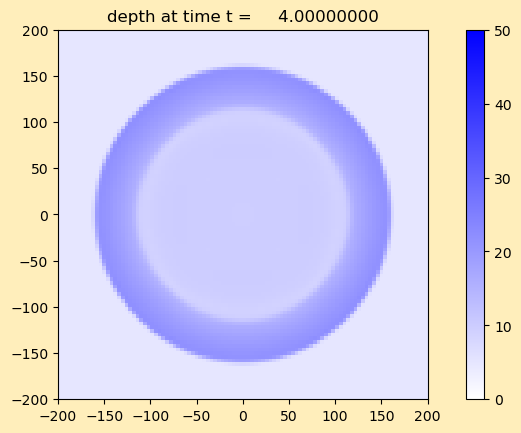

In [15]:
# pcolor plot of depth (figno=1):
png_file = '%s/frame%sfig0.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig1.png


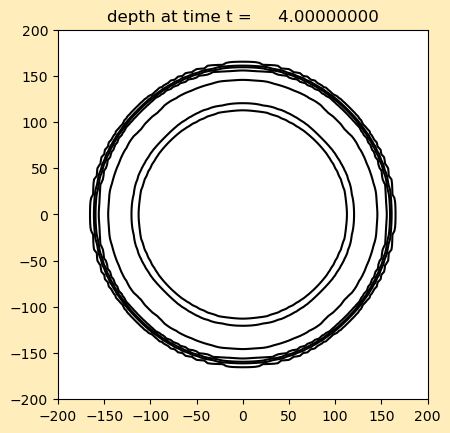

In [16]:
# contour plot of depth (figno=1):
png_file = '%s/frame%sfig1.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig10.png


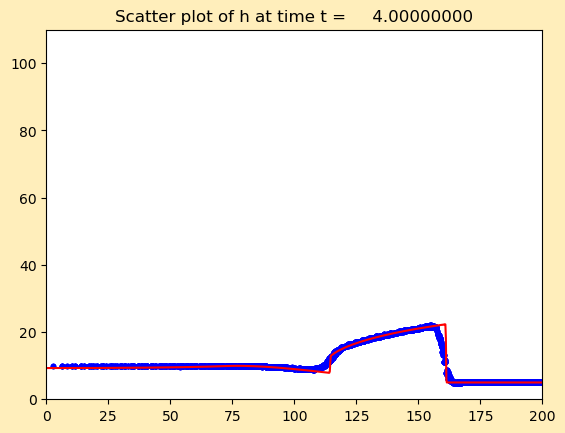

In [17]:
# scatter plot of depth (figno=10):
png_file =  '%s/frame%sfig10.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

### Display an animation inline:

Clicking on the `_PlotIndex` link above, you can view an animation of the results. (This might not work if you run into permission problems with the notebook accessing this webpage.)

After creating all png files in the `_plots` directory, these can also be combined in an animation that is displayed inline:

In [18]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=0,
                                            figsize=figsize_animation);
show_anim(anim)

### Animation of scatter plot (`figno = 10`)

In [19]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=10,
                                            figsize=figsize_animation);
show_anim(anim)

## Assignment

Experiment with the following and produce a few plots and comments on what you observe. Again the main point is to get you more familiar with the code and how to use it, and also to get a better feel for how these methods work and the advantages of the high-resolution methods.

You can do this by adding more cells to this notebook, importing `setrun` and then modifying values as was done in `hw6B.ipynb`, or you can edit `setrun.py` and use the command line to `make .plots`, as you please.  Either way, provide a few illustrative plots with a description of what you did to make them and what you observe.

(a) Using a coarser $50 \times 50$ grid, compare the second-order method that is specified in the current `setrun.py` using

    clawdata.order = 2
    clawdata.transverse_waves = 2
    
with the first-order method 

    clawdata.order = 1
    clawdata.transverse_waves = 1
    
(b) If you set

    clawdata.order = 1
    clawdata.transverse_waves = 0
    
then the transverse Riemann solver is not used, and as with the "donor cell upwind" method for advection, the method is stable only for Courant number $\leq 0.5$. Test this out by trying values of  

    clawdata.cfl_desired
    
that are both above and below 0.5.  Exactly when it starts to show unstability will depend on how large this is, and how fine the grid is.

(c) Compare

    clawdata.cfl_desired = 0.45
    clawdata.order = 1
    clawdata.transverse_waves = 0
    
with

    clawdata.cfl_desired = 0.45
    clawdata.order = 1
    clawdata.transverse_waves = 1
   
Although both are first order accurate (where the solution is smooth), you should observe that including the transverse waves gives a more isotropic solution.


## Part a

In [137]:
import setrun
rundata = setrun.setrun()
clawdata = rundata.clawdata

### Case 1

In [138]:
clawdata.num_cells[0] = 50
clawdata.num_cells[1] = 50

In [139]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(label='1')

Executing shell command:   make output OUTDIR=_output_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/run_output_1.txt

Executing shell command:   make plots OUTDIR=_output_1 PLOTDIR=_plots_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/plot_output_1.txt

View plots created at this link:


/home/cade/Homework/AMATH574/Homework6/radialdam/_plots_1/_PlotIndex.html

displaying _plots_1/frame0004fig0.png


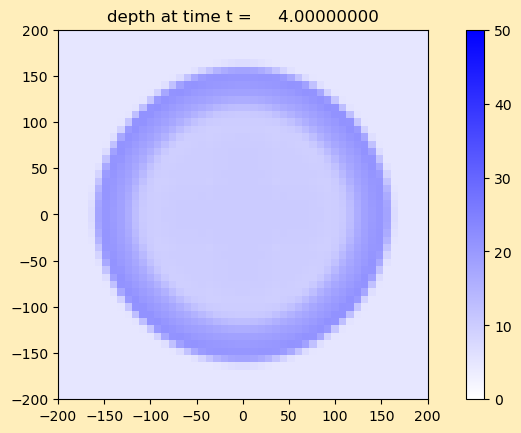

In [140]:
frameno = 4
# pcolor plot of depth (figno=1):
png_file = '%s/frame%sfig0.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig1.png


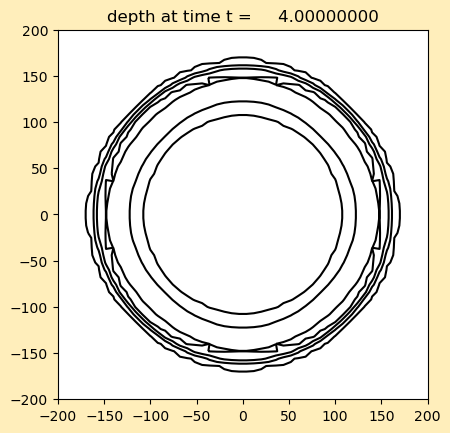

In [141]:
# contour plot of depth (figno=1):
png_file = '%s/frame%sfig1.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig10.png


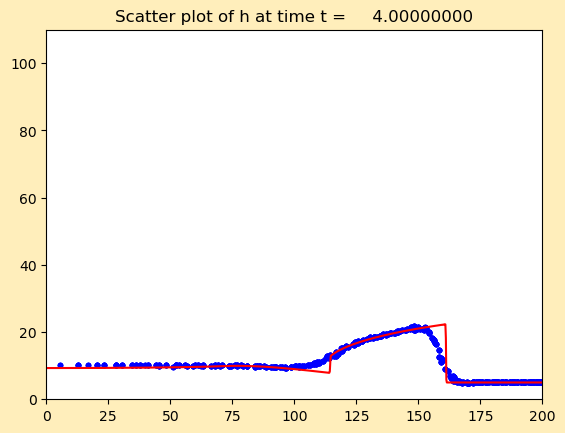

In [106]:
# scatter plot of depth (figno=10):
png_file =  '%s/frame%sfig10.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

In [107]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=0,
                                            figsize=figsize_animation);
show_anim(anim)

In [108]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=10,
                                            figsize=figsize_animation);
show_anim(anim)

On this coarser grid, the second order method does a poor job of approximating the solution around the discontinuities, but this is not too much worse than its performance on the finer grid.

### Case 2

In [109]:
clawdata.order = 1
clawdata.transverse_waves = 1

In [110]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(label='1')

Executing shell command:   make output OUTDIR=_output_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/run_output_1.txt

Executing shell command:   make plots OUTDIR=_output_1 PLOTDIR=_plots_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/plot_output_1.txt

View plots created at this link:


/home/cade/Homework/AMATH574/Homework6/radialdam/_plots_1/_PlotIndex.html

displaying _plots_1/frame0004fig0.png


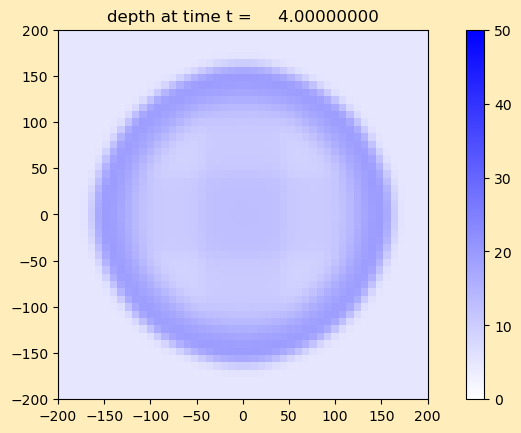

In [111]:
frameno = 4
# pcolor plot of depth (figno=1):
png_file = '%s/frame%sfig0.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig1.png


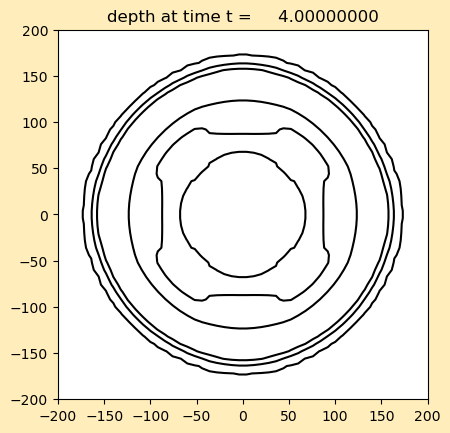

In [112]:
# contour plot of depth (figno=1):
png_file = '%s/frame%sfig1.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig10.png


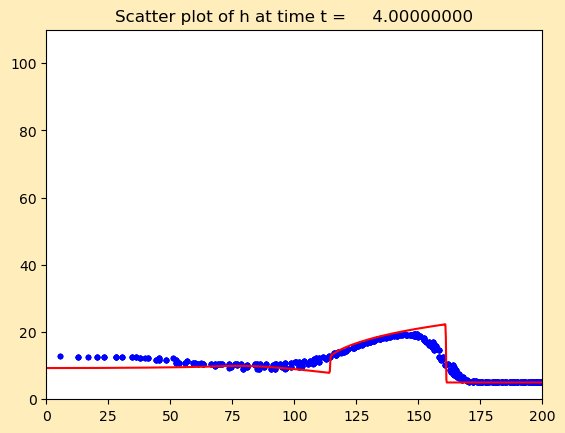

In [113]:
# scatter plot of depth (figno=10):
png_file =  '%s/frame%sfig10.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

In [114]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=0,
                                            figsize=figsize_animation);
show_anim(anim)

In [115]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=10,
                                            figsize=figsize_animation);
show_anim(anim)

The first order method does considerably worse than the second order method, failing to get a decent approximation even away from the discontinuities. 

## Part b

### Case 1

In [116]:
clawdata.num_cells[0] = 100
clawdata.num_cells[1] = 100
clawdata.order = 1
clawdata.transverse_waves = 0
clawdata.cfl_desired = 0.8

In [117]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(label='1')

Executing shell command:   make output OUTDIR=_output_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/run_output_1.txt

Executing shell command:   make plots OUTDIR=_output_1 PLOTDIR=_plots_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/plot_output_1.txt

View plots created at this link:


/home/cade/Homework/AMATH574/Homework6/radialdam/_plots_1/_PlotIndex.html

displaying _plots_1/frame0004fig0.png


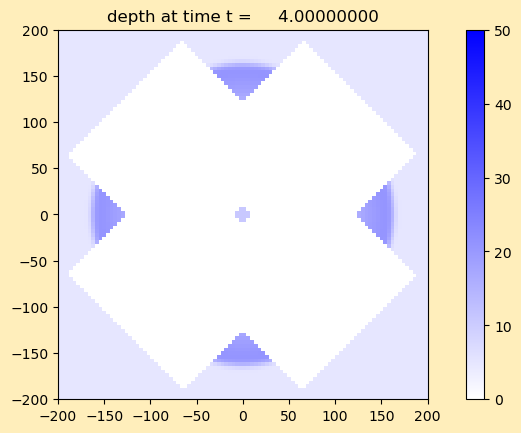

In [118]:
frameno = 4
# pcolor plot of depth (figno=1):
png_file = '%s/frame%sfig0.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig1.png


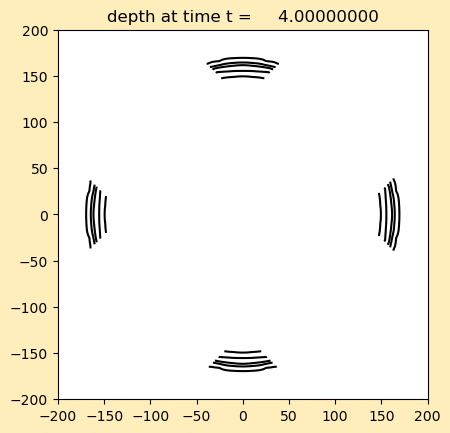

In [119]:
# contour plot of depth (figno=1):
png_file = '%s/frame%sfig1.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig10.png


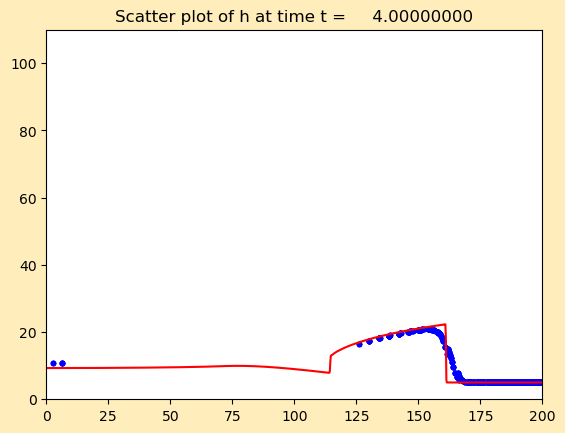

In [120]:
# scatter plot of depth (figno=10):
png_file =  '%s/frame%sfig10.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

In [121]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=0,
                                            figsize=figsize_animation);
show_anim(anim)

In [122]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=10,
                                            figsize=figsize_animation);
show_anim(anim)

As expected, the method with CFL number larger than $0.5$ blows up horribly and fails to produce a meaningful solution.

### Case 2

In [130]:
clawdata.cfl_desired = 0.3

In [131]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(label='1')

Executing shell command:   make output OUTDIR=_output_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/run_output_1.txt

Executing shell command:   make plots OUTDIR=_output_1 PLOTDIR=_plots_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/plot_output_1.txt

View plots created at this link:


/home/cade/Homework/AMATH574/Homework6/radialdam/_plots_1/_PlotIndex.html

displaying _plots_1/frame0004fig0.png


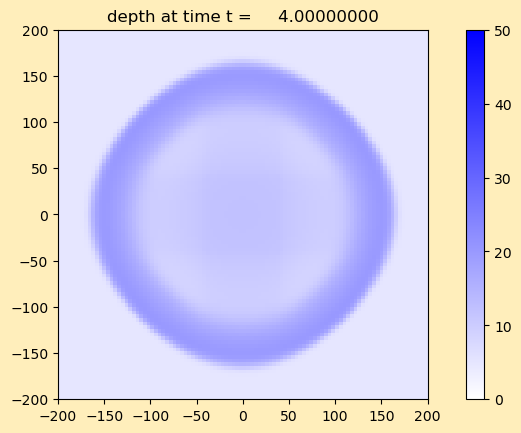

In [132]:
frameno = 4
# pcolor plot of depth (figno=1):
png_file = '%s/frame%sfig0.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig1.png


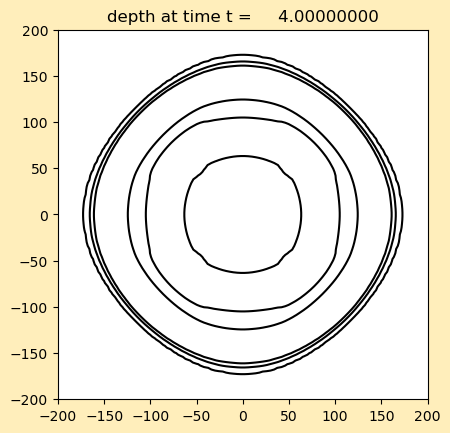

In [133]:
# contour plot of depth (figno=1):
png_file = '%s/frame%sfig1.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig10.png


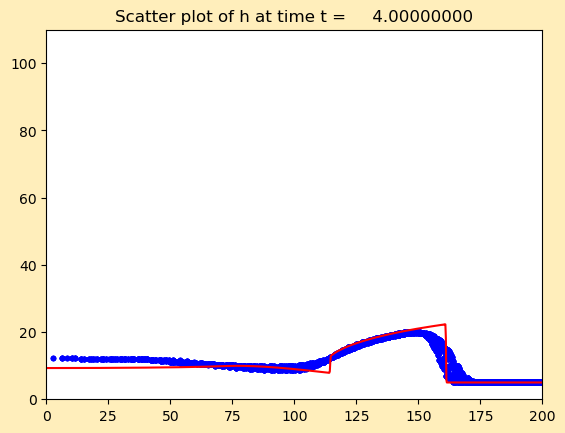

In [134]:
# scatter plot of depth (figno=10):
png_file =  '%s/frame%sfig10.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

In [135]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=0,
                                            figsize=figsize_animation);
show_anim(anim)

In [136]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=10,
                                            figsize=figsize_animation);
show_anim(anim)

Once we consider a reasonable CFL number, we observe behavior much more in line with part a and the original solution.

## Part c

### Case 1

In [142]:
clawdata.cfl_desired = 0.45
clawdata.order = 1
clawdata.transverse_waves = 0

In [143]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(label='1')

Executing shell command:   make output OUTDIR=_output_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/run_output_1.txt

Executing shell command:   make plots OUTDIR=_output_1 PLOTDIR=_plots_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/plot_output_1.txt

View plots created at this link:


/home/cade/Homework/AMATH574/Homework6/radialdam/_plots_1/_PlotIndex.html

displaying _plots_1/frame0004fig0.png


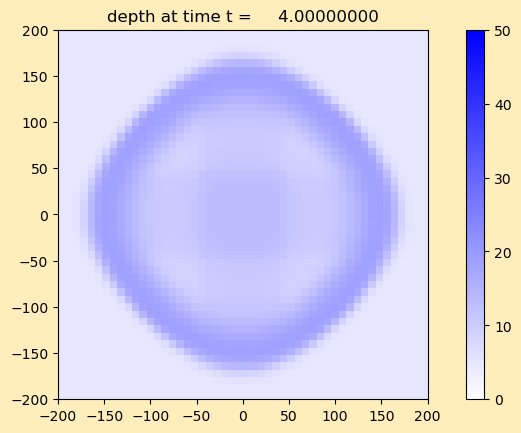

In [144]:
frameno = 4
# pcolor plot of depth (figno=1):
png_file = '%s/frame%sfig0.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig1.png


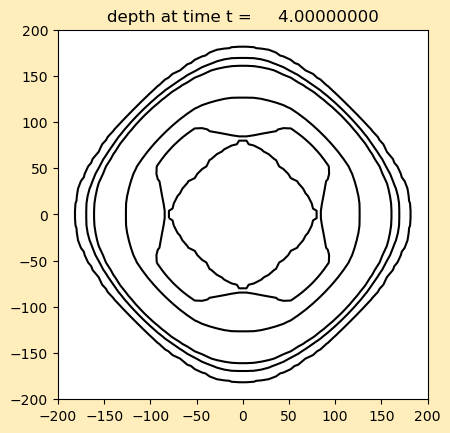

In [145]:
# contour plot of depth (figno=1):
png_file = '%s/frame%sfig1.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig10.png


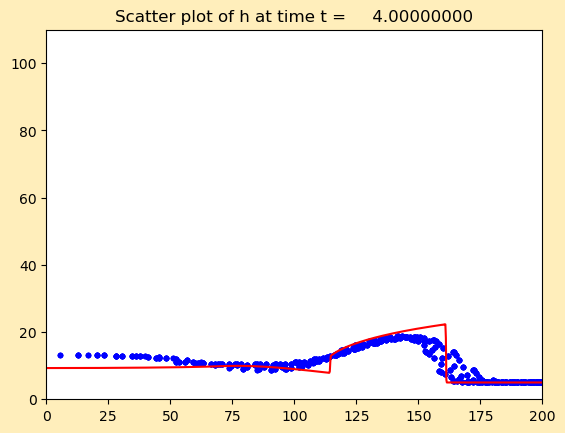

In [146]:
# scatter plot of depth (figno=10):
png_file =  '%s/frame%sfig10.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

In [147]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=0,
                                            figsize=figsize_animation);
show_anim(anim)

In [148]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=10,
                                            figsize=figsize_animation);
show_anim(anim)

The solution looks somewhat reasonable in time, but the wireframe seems to preform particularly poorly.

### Case 2

In [149]:
clawdata.cfl_desired = 0.45
clawdata.order = 1
clawdata.transverse_waves = 1

In [150]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(label='1')

Executing shell command:   make output OUTDIR=_output_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/run_output_1.txt

Executing shell command:   make plots OUTDIR=_output_1 PLOTDIR=_plots_1
Done...  Check this file to see output:


/home/cade/Homework/AMATH574/Homework6/radialdam/plot_output_1.txt

View plots created at this link:


/home/cade/Homework/AMATH574/Homework6/radialdam/_plots_1/_PlotIndex.html

displaying _plots_1/frame0004fig0.png


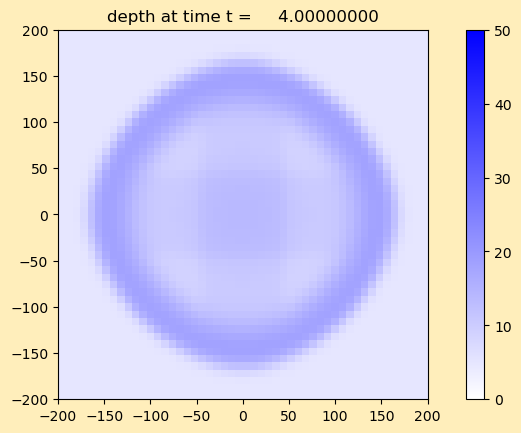

In [151]:
frameno = 4
# pcolor plot of depth (figno=1):
png_file = '%s/frame%sfig0.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig1.png


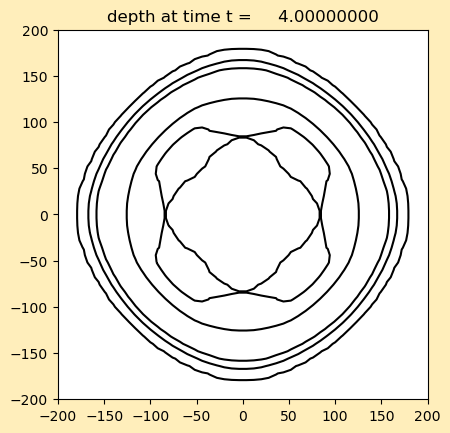

In [152]:
# contour plot of depth (figno=1):
png_file = '%s/frame%sfig1.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

displaying _plots_1/frame0004fig10.png


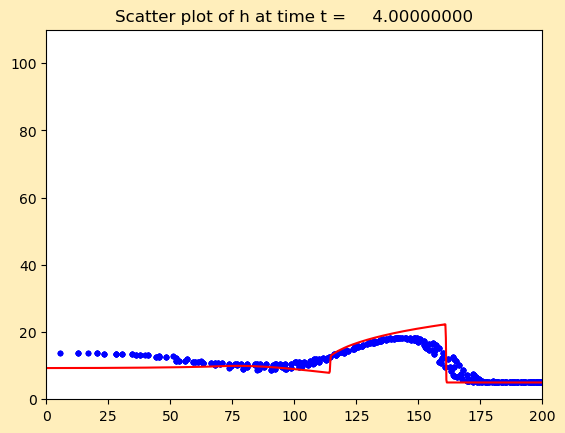

In [153]:
# scatter plot of depth (figno=10):
png_file =  '%s/frame%sfig10.png' % (plotdir, str(frameno).zfill(4))
print('displaying %s' % png_file)
Image(png_file, width=width_image)

In [154]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=0,
                                            figsize=figsize_animation);
show_anim(anim)

In [155]:
anim = animation_tools.animate_from_plotdir(plotdir,figno=10,
                                            figsize=figsize_animation);
show_anim(anim)

This looks comparable to what we saw in the other case but still doesn't perform well.